In [1]:
# Getting data from git repo
!git clone https://github.com/SiddheshKanawade/Real-Time-Tracking.git
%cd Real-Time-Tracking

Cloning into 'Real-Time-Tracking'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.
/content/Real-Time-Tracking


In [33]:
import cv2
import numpy as np
import os
import timeit
import math

from datetime import timedelta
from numpy.linalg import norm, inv
from scipy.stats import multivariate_normal as mv_normal
from PIL import Image as im

In [34]:
def get_frames_dur(cap, saving_fps):
    """ Returns the list of durations"""
    s = []
    vid_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    for i in np.arange(0, vid_duration, 1 / saving_fps):
        s.append(i)
    return s

def format_timedelta(time_delta):
    """Sanitize time format"""
    formated_time = str(time_delta)
    try:
        formated_time, ms = formated_time.split(".")
    except ValueError:
        return (formated_time + ".00").replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{formated_time}.{ms:02}".replace(":", "-")

In [35]:
video_footage = "/content/Real-Time-Tracking/20221109_144659-2.mp4"

file_name = "frames_dir"
import shutil

if os.path.isdir(file_name):
  shutil.rmtree(file_name)


In [36]:
SAVING_FPS = 15
frames = []

if not os.path.isdir(file_name):
  os.mkdir(file_name)
    
video_file = cv2.VideoCapture(video_footage)

fps = video_file.get(cv2.CAP_PROP_FPS)
print("FPS: ", fps)

saving_frames_per_second = min(fps, SAVING_FPS)

saving_frames_durations = get_frames_dur(video_file, saving_frames_per_second)

frame_count = 0
count = 0

while True:
  is_read_frames, frame = video_file.read()
  if not is_read_frames:
    break

  frame_duration = frame_count / fps
  try:
    closest_duration = saving_frames_durations[0]
  except IndexError:
      break
  if frame_duration >= closest_duration:
    frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
    img = im.fromarray(frame)
    img = img.resize((140,100), im.ANTIALIAS)
    frame = np.array(img)
    cv2.imwrite(os.path.join(file_name, f"frame{frame_duration_formatted}.jpg"), frame) 
    frames.append(frame)

    count += 1
    try:
        saving_frames_durations.pop(0)
    except IndexError:
        pass

  frame_count += 1
frames = np.array(frames)

FPS:  30.00523900998587


In [37]:
print(f"File count in {file_name} is {count}")
print("Shape of a frame is {}".format(frames.shape))

File count in frames_dir is 42
Shape of a frame is (42, 100, 140, 3)


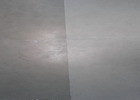

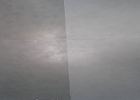

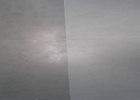

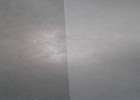

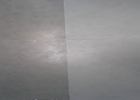

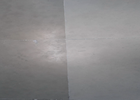

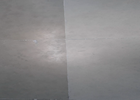

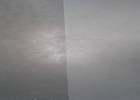

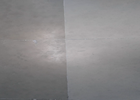

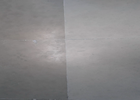

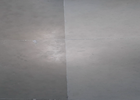

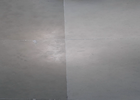

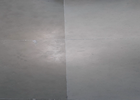

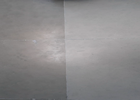

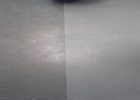

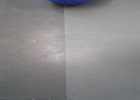

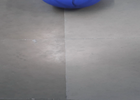

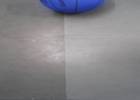

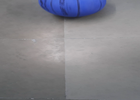

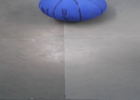

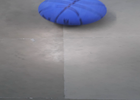

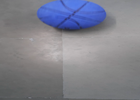

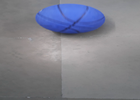

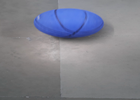

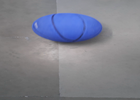

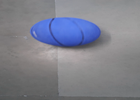

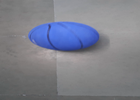

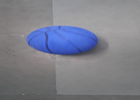

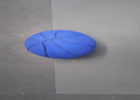

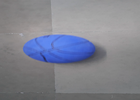

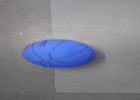

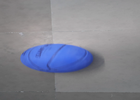

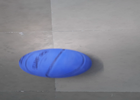

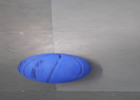

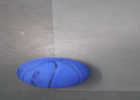

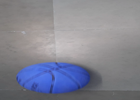

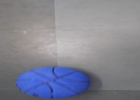

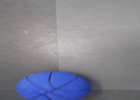

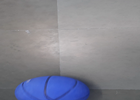

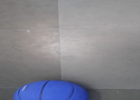

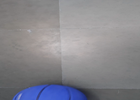

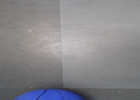

In [38]:
for i in range(count):
  data = im.fromarray(frames[i])
  display(data)

In [39]:
def is_match_guassian(pixel,mean,sigma):
  '''
  check whether a pixel match a Gaussian distribution. Matching means pixel is less than
  2.5 standard deviations away from a Gaussian distribution.
  '''
  x = np.mat(np.reshape(pixel, (3, 1)))
  u = np.mat(mean).T
  sigma = np.mat(sigma)
  
  # calculate Mahalanobis distance
  mahalanobis_d = np.sqrt((x-u).T*sigma.I*(x-u))
  if mahalanobis_d < 2.5:
      return True
  else:
      return False

In [40]:
ROW,COL,RGB = frames[0].shape
print(ROW,COL)
num_frames = frames.shape[0]

100 140


In [41]:
#Gaussian Mixture Models Algorithm
K = 4
threshold = 0.85
init_weights = [0.8, 0.01, 0.1, 0.09]
init_mean = np.zeros(3)

# initial Covariance matrix
init_sigma = 255*np.eye(3)
init_alpha = 0.1

weights = np.array([[init_weights for j in range(COL)] for i in range(ROW)])
mean = np.array([[[init_mean for k in range(K)] for j in range(COL)]
                             for i in range(ROW)])
sigma = np.array([[[init_sigma for k in range(K)] for j in range(COL)]
                             for i in range(ROW)])

B = np.ones((ROW,COL),dtype=int)
alpha = init_alpha
start_time = timeit.default_timer()
#Initializing the distribution for pixels for the first image, taking mean = pixel value
for i in range(ROW):
  for j in range(COL):
      for k in range(K):
          mean[i][j][k] = np.array(frames[0][i][j]).reshape(1,3)

for f in range(1,num_frames,1):
  img = frames[f]
  for i in range(ROW):
    for j in range(COL):
        match = -1
        for k in range(K):
            if is_match_guassian(img[i][j], mean[i][j][k], sigma[i][j][k]):
                match = k
                mu = mean[i][j][k]
                sig = sigma[i][j][k]
                x = img[i][j].astype(float)
                delta = x - mu
                rho = alpha * mv_normal.pdf(img[i][j], mu, sig)
                weights[i][j] = (1 - alpha) * weights[i][j]
                weights[i][j][k] += alpha
                mean[i][j][k] = mu + rho * delta
                sigma[i][j][k] = sig + rho * (np.matmul(delta, delta.T) - sig)

        if match == -1:
            w_list = [weights[i][j][k] for k in range(K)]
            id = w_list.index(min(w_list))
            mean[i][j][id] = np.array(img[i][j]).reshape(1, 3)
            sigma[i][j][id] = np.array(init_sigma)
  
  '''
  reorder the estimated components based on the ratio pi / the norm of standard deviation.
  '''
  for i in range(ROW):
      for j in range(COL):
          k_weight = weights[i][j]
          k_norm = np.array([norm(np.sqrt(sigma[i][j][k])) for k in range(K)])
          ratio = k_weight/k_norm
          descending_indices = np.argsort(-ratio)

          weights[i][j] = weights[i][j][descending_indices]
          mean[i][j] = mean[i][j][descending_indices]
          sigma[i][j] = sigma[i][j][descending_indices]

          cum_weight = 0
          T = threshold
          for index in range(K):
              cum_weight += weights[i][j][index]
              if cum_weight > T:
                  B[i][j] = index + 1
                  break

end_time = timeit.default_timer()

print(f"Total execution time: {end_time-start_time}")

Total execution time: 898.0984560360002


In [42]:
# Remove the file named Output, if it is present
if os.path.isdir("Output"):
  shutil.rmtree("Output")
  os.mkdir("Output")  

In [43]:
outputs = []
for ind in range(num_frames):
  img = frames[ind]
  result = np.array(img)
  for i in range(ROW):
    for j in range(COL):
        for k in range(B[i][j]):
            if is_match_guassian(img[i][j], mean[i][j][k], sigma[i][j][k]):
                result[i][j] = [0,0,0]
                break
  outputs.append(result)

In [ ]:
for i in range(num_frames):
  data = im.fromarray(outputs[i],'RGB')
  display(data)

In [ ]:
for i in range(num_frames):
  out = outputs[i]
  cv2.imwrite(os.path.join("Output", f"output{str(i)}.jpg"),out)

In [46]:
bg_sub = cv2.createBackgroundSubtractorMOG2();

result_inbuilt = []
for i in range(num_frames):
  img = bg_sub.apply(frames[i])
  result_inbuilt.append(img)

In [47]:
from google.colab.patches import cv2_imshow

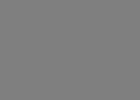

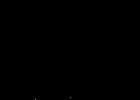

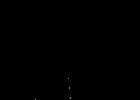

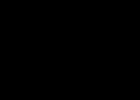

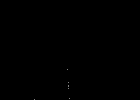

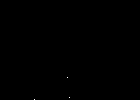

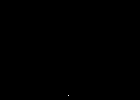

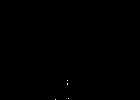

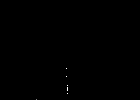

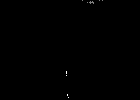

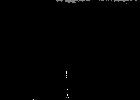

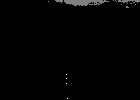

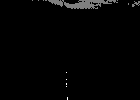

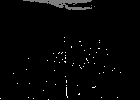

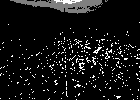

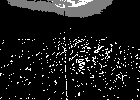

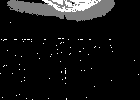

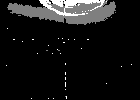

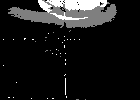

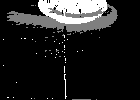

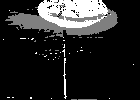

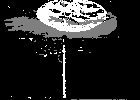

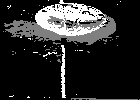

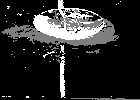

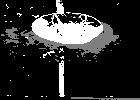

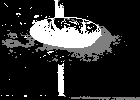

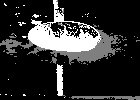

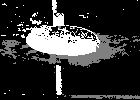

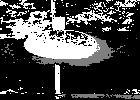

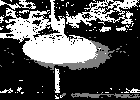

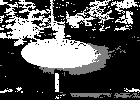

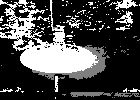

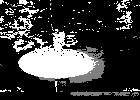

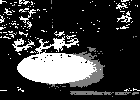

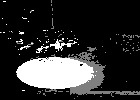

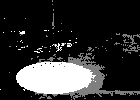

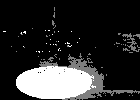

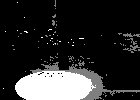

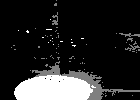

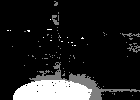

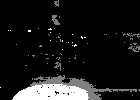

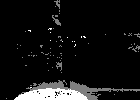

In [48]:
for i in range(num_frames):
  cv2_imshow(result_inbuilt[i])

In [49]:
def RMSE(y_actual, y_predicted):
  MSE = np.square(np.subtract(y_actual,y_predicted)).mean()
  return math.sqrt(MSE) 

In [50]:
MIN_RMSE = 100
MAX_RMSE = 0

res = []
for ind in range(num_frames):
  img = frames[ind]
  a = np.zeros((ROW,COL))
  for i in range(ROW):
    for j in range(COL):
      a[i][j] = 0.299*img[i][j][0] + 0.587*img[i][j][1] + 0.114*img[i][j][2]
  res.append(a)

for i in range(num_frames):

  rmse = RMSE(result_inbuilt[i],res[i])
  MIN_RMSE = min(MIN_RMSE,rmse)
  MAX_RMSE = max(MAX_RMSE,rmse)

print("Minimum RMSE between our GMM and inbuilt function: {0:.2f}".format(MIN_RMSE))
print("Maximum RMSE between our GMM and inbuilt function: {0:.2f}".format(MAX_RMSE))

Minimum RMSE between our GMM and inbuilt function: 25.06
Maximum RMSE between our GMM and inbuilt function: 142.78
